In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import os
from torchvision import transforms
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm
import random
import torch.nn as nn
from hybrid_model_v3 import HybridSegModel

In [4]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [9]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import os
from torchvision import transforms
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms.functional as tx
import random
import cv2
from PIL import ImageEnhance
from skimage.exposure import match_histograms
import torchvision.transforms as T
import torchvision.transforms.functional as F
class GE_Thyroid_Dataset(Dataset):
    def __init__(self, csv_file, transform, image_size):
        self.df = pd.read_csv(csv_file)
        self.transform = transform
        self.image_size = image_size
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_name = self.df["image_name"][idx]
        mask_name = self.df["mask_name"][idx]
        image_type = self.df["image_type"][idx]

        if image_type == "train":
            from_folder = "../ge_data/train"
        else:
            from_folder = "../ge_data/test"

        image_path = f"{from_folder}/images/{image_name}"
        mask_path = f"{from_folder}/masks/{mask_name}"

        image = Image.open(image_path).convert("L")
        mask = Image.open(mask_path).convert("L")
        
        image_tensor, mask_tensor = self.transform(image, mask, self.image_size)
        mask_tensor = (mask_tensor > 0.5).float()

        return image_tensor, mask_tensor, mask_name, image_type

In [55]:
image_size = 128
batch_size = 1
def train_augmentation(image, mask, image_size):
    resize = T.Resize((image_size, image_size))
    image = resize(image)
    mask = resize(mask)

    image_tensor = tx.to_tensor(image)
    mask_tensor = tx.to_tensor(mask)

    # If standardization
    mean = image_tensor.mean()
    std = image_tensor.std()
    std = std if std > 0 else 1.0  # avoid division by zero
    image_tensor = (image_tensor - mean) / std
    return image_tensor, mask_tensor


train_dataset = GE_Thyroid_Dataset("../ge_data/train_csv_for_finetune(1).csv", transform = train_augmentation, image_size = image_size)
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

image, mask, mask_name, image_type = next(iter(train_dataloader))

In [56]:

inference_name = "hybrid_v3_baseline"

model = HybridSegModel(in_channels = 1, out_channels = 2, output_size = 128, layers_num = 3)
checkpoint = torch.load(f"models/{inference_name}/best_checkpoint.pth", map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

<All keys matched successfully>

In [68]:
image, mask, mask_name, image_type = next(iter(train_dataloader))
outputs = model(image)
print(outputs.shape)
outputs = nn.Sigmoid()(outputs)

torch.Size([1, 2, 128, 128])


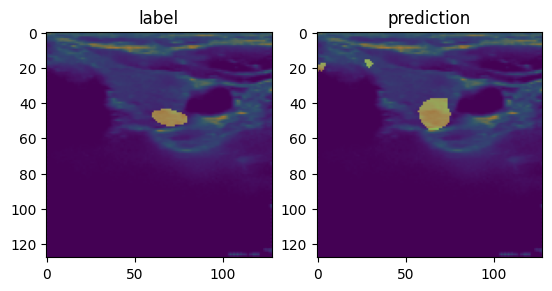

In [69]:

for index in range(outputs.shape[0]):
    plt.subplot(1,2,1)
    plt.imshow(image[index][0])
    plt.imshow(mask[index][0], alpha = 0.5)
    plt.title("label")
    
    outputs = outputs>0.5
    plt.subplot(1,2,2)
    plt.imshow(image[index][0])
    plt.imshow(outputs[index][0].detach().cpu().numpy(), alpha = 0.5)
    plt.title("prediction")
    plt.show()

In [70]:
nodule_mask = outputs[:, 0].detach().numpy().astype(np.uint8).squeeze()
print(nodule_mask.shape)

(128, 128)


In [71]:
def draw_bounding_boxes_to_mask(mask):
    binary_mask = (mask > 0).astype(np.uint8)
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    new_mask = np.zeros_like(mask, dtype=np.uint8)

    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        cv2.rectangle(new_mask, (x, y), (x + w, y + h), color=1, thickness=-1)  # 填滿框

    return new_mask

In [72]:
new_mask = draw_bounding_boxes_to_mask(nodule_mask)

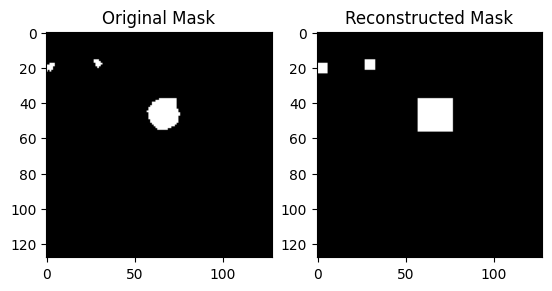

In [73]:
import matplotlib.pyplot as plt

plt.subplot(1, 2, 1)
plt.title("Original Mask")
plt.imshow(nodule_mask, cmap='gray')

plt.subplot(1, 2, 2)
plt.title("Reconstructed Mask")
plt.imshow(new_mask, cmap='gray')

plt.show()

AttributeError: 'tuple' object has no attribute 'shape'